In [1]:
from datetime import datetime

In [2]:
%reload_ext autoreload

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from code.data import Data

In [4]:
data = Data("lastfm-dataset-1K\userid-timestamp-artid-artname-traid-traname.tsv")

Skipping line 2120260: expected 6 fields, saw 8

Skipping line 2446318: expected 6 fields, saw 8

Skipping line 11141081: expected 6 fields, saw 8

Skipping line 11152099: expected 6 fields, saw 12
Skipping line 11152402: expected 6 fields, saw 8

Skipping line 11882087: expected 6 fields, saw 8

Skipping line 12902539: expected 6 fields, saw 8
Skipping line 12935044: expected 6 fields, saw 8

Skipping line 17589539: expected 6 fields, saw 8



==== Model user_previous_tracks ====


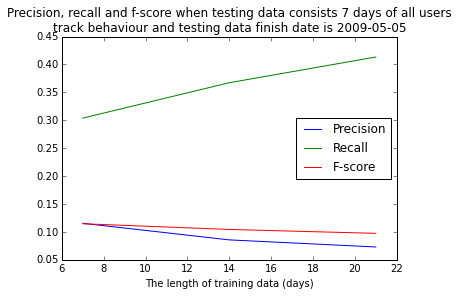

In [17]:
from code.experiments import Experiment
training_lengths = [21,14,7]#[28,21,14,7,4,3,2,1]
testing_lengths = [7]
testing_finish_dates = [datetime(2009, 5, 5)]#, datetime(2009, 4, 28), datetime(2009, 1, 1)]

experiment = Experiment(training_lengths, testing_lengths, testing_finish_dates)
experiment.run(data, 1, as_graph=True)

In [7]:
id_2 = data.create_experiment_data(21, 7, datetime(2009, 5, 5), 2)

In [19]:
from code.models import Model
model = Model('all_previous_tracks', data, id_2)
model.run()

==== all_previous_tracks ====
Model precision: 0.000376851069159
Model recall: 0.729049401278
F1 score: 0.000752194594366


(0.00037685106915876133, 0.7290494012776494, 0.0007521945943660343)

In [20]:
from code.models import Model
model = Model('all_previous_tracks', data, id_0)
model.run()

==== all_previous_tracks ====
Model precision: 0.000624075225112
Model recall: 0.579352212458
F1 score: 0.00124310423208


(0.0006240752251117361, 0.5793522124578825, 0.0012431042320759974)

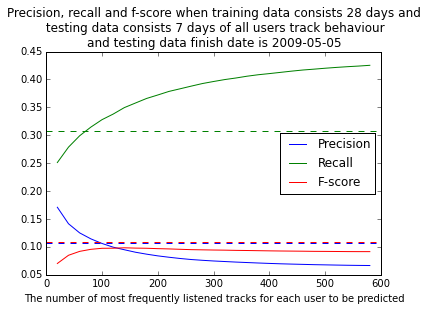

In [24]:
from code.experiments import *
n_values = [i for i in xrange(0, 600, 20)]
experiment = NMostOftenExperiment(28, 7, datetime(2009, 5, 5), data, 2, n_values)
experiment.run()

The modularity of the network is 0.997703


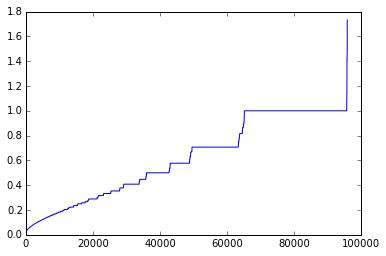

In [19]:
from code.clustering import TrackClustering
id_0 = data.create_experiment_data(7, 7, datetime(2009, 5, 5), 0, True)
training_data = data.get_training_data(id_0)
clustering = TrackClustering(training_data, 60, 0.5)
clustering.run(plot_similarities=True)

In [21]:
# Pick randomly from cluster
from code.models import Model
model = Model('from_clusters', data, id_0, cluster=clustering)
model.run()

==== from_clusters ====
Model precision: 0.0942905698813
Model recall: 0.274801121538
F1 score: 0.0932627215797


(0.09429056988130449, 0.274801121538349, 0.09326272157973355)

In [ ]:
# Pick everything from the same clusters

In [136]:
from datetime import datetime

window_in_mins = (datetime.strptime(finish, "%Y-%m-%d 00:00:00") - datetime.strptime(begin, "%Y-%m-%d 00:00:00")).days * 24.0

In [137]:
for f in cluster_freq:
    cluster_freq[f] = window_in_mins/cluster_freq[f] 

In [138]:
[(c, cluster_freq[c]) for c in sorted(cluster_freq, key=lambda x: cluster_freq[x])]

[(491, 5.333333333333333),
 (5804, 5.894736842105263),
 (7065, 9.333333333333334),
 (4014, 10.181818181818182),
 (2403, 14.608695652173912),
 (8484, 19.764705882352942),
 (4905, 22.4),
 (17090, 24.0),
 (6227, 25.846153846153847),
 (11028, 48.0),
 (20465, 84.0),
 (9867, 112.0),
 (10562, 112.0),
 (17539, 168.0),
 (4648, 168.0),
 (8640, 168.0),
 (7375, 168.0),
 (12504, 168.0),
 (9843, 168.0),
 (14089, 336.0),
 (12648, 336.0),
 (13695, 336.0)]

In [161]:
len(clusters[13695])

1

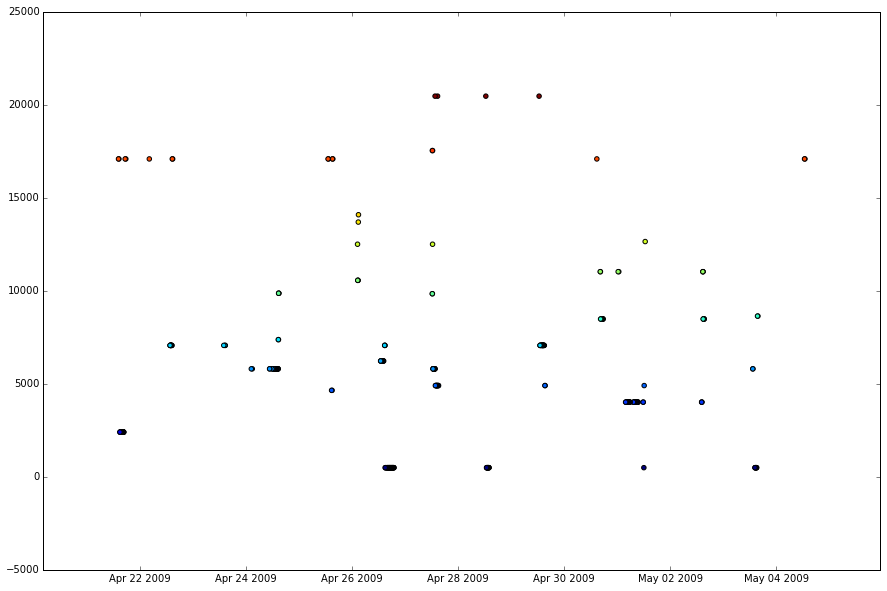

In [117]:
plt.figure(figsize=(15,10), dpi=1000)
axes = plt.gca()
#axes.set_xlim(['2009-05-04 13:06:09','2009-04-21 14:16:27'])
plt.scatter(times, cluster_ids, c=cluster_ids)

In [45]:
print len(CmtyV)
print len([x for x in CmtyV if len(x) > 1])

23237
9860


In [46]:
l = [len(a) for a in CmtyV]

In [47]:
l.sort()
l[-10:]

[245, 248, 280, 287, 291, 300, 304, 342, 344, 355]

In [48]:
s = [a for a in CmtyV if len(a) == 5]

In [49]:
for a in s[0]:
    print labels[a]

Shiola
Loathsome
Splinters Through A Straw
Catching Feathers
Death Salvation


In [21]:
id_2 = data.create_experiment_data(7, 7, datetime(2009, 5, 5), 2)

In [22]:
tr_d = data.get_training_data(id_2)

In [45]:
tr_d

,user_id,timestamp,track_id,track_name
219,user_000001,2009-04-27 15:12:38,996c807f-68df-4a23-aa2d-8ccd9b71b1da,The Lords Of Sanity
220,user_000001,2009-04-27 15:04:51,1c558d0d-34fd-44e1-9abd-28f86d454cf7,Up The Beach
221,user_000001,2009-04-27 14:57:54,d1de63b3-fb80-46bc-befa-8e55076b379a,The Crush
222,user_000001,2009-04-27 14:45:21,6f69766e-d6f9-4086-971e-1be5f9c0d660,Slightly
223,user_000001,2009-04-27 14:44:44,6bec4dc2-1900-4900-ace0-2a8428cff9ae,Btw
224,user_000001,2009-04-27 14:35:05,8f8e963f-2821-4eb6-b6ff-7dc361b3a536,To Last
225,user_000001,2009-04-27 14:28:46,0e432672-675c-42fe-b164-d7fd728c0cee,Deuce
226,user_000001,2009-04-27 14:21:14,ffb38aab-0144-4c9b-8fcf-8f6dff4362fd,Gridlock
227,user_000001,2009-04-27 14:14:03,342b9c70-57d3-4d44-bdb0-ae3f3e5af5e0,Sunlite
228,user_000001,2009-04-27 14:07:43,274f7902-9df9-419b-ab3d-e5844dbd7a42,Vacuum Stance
